### Import Libraries


In [21]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


In [1]:
import nxviz

/anaconda2/envs/py36_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load data from csv files


In [48]:
email_tbl = pd.read_csv('email_table.csv')

100000

In [4]:
email_tbl.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [49]:
email_opnd = pd.read_csv('email_opened_table.csv')

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [6]:
email_opnd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [50]:
link_tbl = pd.read_csv('link_clicked_table.csv')

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [51]:
print('email_table.csv:', len(email_tble['email_id'].unique()))
print('email_opened_table.csv:', len(email_opnd['email_id'].unique()))
print('link_clicked_table.csv:', len(link_tbl['email_id'].unique()))


email_table.csv:	 100000
email_opened_table.csv:	 10345
link_clicked_table.csv:	 2119


In [52]:
email_subject = pd.read_csv('examiner-date-text.csv', delimiter=',', nrows = 100000, usecols=["headline_text"])
email_subject['subject'] = email_subject['headline_text'].str.split(' ',1).str[1]
del email_subject['headline_text']
email_subject.subject=email_subject.subject.astype(str)


                                             subject
0           Most Anticipated books releasing in 2010
1          best films of 2009 - What's on your list?
2  days of free admission at Lan Su Chinese Garde...
3         PlayStation games to watch out for in 2010
4  resolutions for a Happy New Year for you and y...


### Recommendation System Implementation


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Create a TF-IDF Vectorizer Object. 
tfidf = TfidfVectorizer(stop_words='english')

#Create the TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(email_subject['subject'])

#shape of tfidf_matrix
tfidf_matrix.shape

(100000, 42100)

In [7]:
from sklearn.metrics.pairwise import linear_kernel

#cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [8]:
#Construct a reverse map of indices and email subjects
indices = pd.Series(email_subject.index, index=email_subject['subject']).drop_duplicates()

In [9]:
# Function that takes in movie title as input and outputs most similar movies
def get_subjectrecommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    print('Similarity Scores:',sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return email_subject['subject'].iloc[movie_indices]

In [10]:
output = get_subjectrecommendations('Most Anticipated books releasing in 2010')


Similarity Scores: [(33539, 0.5422069222985719), (73783, 0.5422069222985719), (16877, 0.48838584345829844), (6893, 0.44507768326162933), (11567, 0.44115615698234634), (76431, 0.44115615698234634), (85609, 0.44115615698234634), (97493, 0.44115615698234634), (97895, 0.44115615698234634), (5292, 0.4348892589385753)]


In [11]:
print(output)

33539    5 most anticipated games of 2010
73783    8 most anticipated games of 2010
16877     most anticipated albums of 2010
6893         anticipated PC games of 2010
11567                             & books
76431                        of the books
85609                               Books
97493                 books, then and now
97895                               Books
5292              Most Anticipated Albums
Name: subject, dtype: object


### Prepare data for network analysis


In [11]:
labld_email = pd.read_csv('email_labeled.csv', usecols=["From", "To","Date"])


In [12]:
len(labld_email.To.unique())

11051

In [13]:
labld_email['From'] = labld_email['From'].str.lstrip('frozenset({\'').str.rstrip('\'})')
labld_email['To'] = labld_email['To'].str.lstrip('frozenset({\'').str.rstrip('\'})')
labld_email['To'] = labld_email['To'].str.replace("@aol.com", "@gmail.com")
labld_email['To'] = labld_email['To'].str.replace("@enron.com", "@gmail.com")


In [53]:
email_opnd['opened'] = 1
link_tbl['clicked'] = 1
data = pd.merge(left=email_tbl, right=email_opnd, how='left', on='email_id')
data = pd.merge(left=data, right=link_tbl, how='left', on='email_id')
data = data.fillna(value=0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
#data=pd.concat([data,email_subject], axis=1)
#data=pd.concat([data,labeled_email], axis=1)

data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [18]:
data[['email_id','Date','From','To']].head()

,email_id,Date,From,To
0,85120,2000-09-14 17:15:00,vince.kaminski@enron.com,vkaminski@gmail.com
1,966622,2001-05-07 15:39:00,vince.kaminski@enron.com,.baker@gmail.com
2,777221,2001-05-04 17:37:00,vince.kaminski@enron.com,vkaminski@gmail.com
3,493711,2001-04-16 16:30:00,vince.kaminski@enron.com,ugenio.perez@gmail.com
4,106887,2000-09-14 16:01:00,vince.kaminski@enron.com,vkaminski@gmail.com


### Imbalanced class


0    97881
1     2119
Name: clicked, dtype: int64

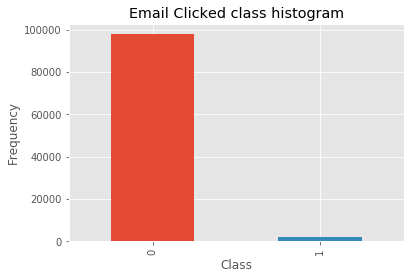

In [16]:
pd.value_counts(data['clicked']).plot.bar()
plt.title('Email Clicked class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
data['clicked'].value_counts()

In [15]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', data['opened'].mean() * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', data['clicked'].mean() * 100))


Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


In [16]:
data.groupby('clicked')['email_id'].count() / len(data)


clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

In [18]:
len(data.From.unique())


6601

### Network analysis plots


2119


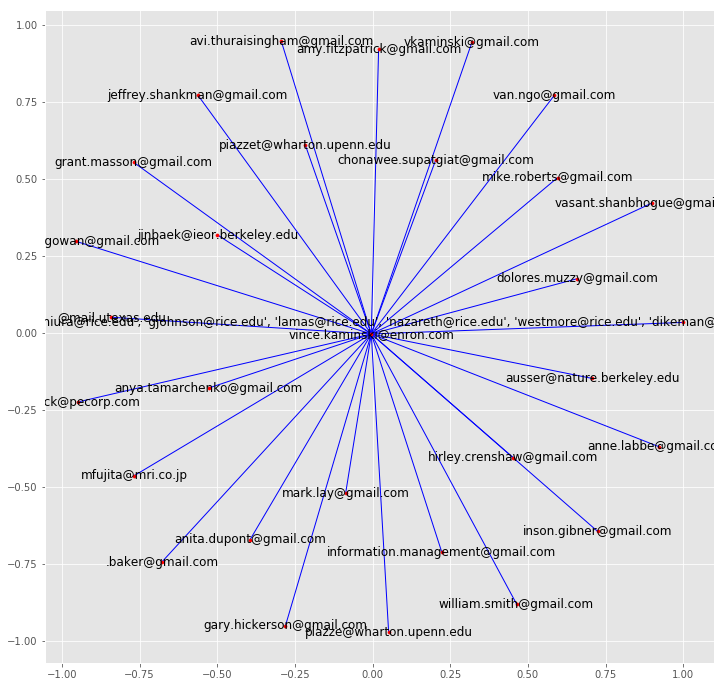

In [86]:
import networkx as nx
import nxviz as nv

d = data.loc[data['clicked'] == 1]

print(len(d))
#d = data[:500]

d = d[(d.index < 2119)]

G = nx.from_pandas_edgelist(d, 'From', 'To', edge_attr=['Date','subject'])
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, pos, node_size=10, node_color='red', with_labels=True, edge_color='blue')
plt.show()

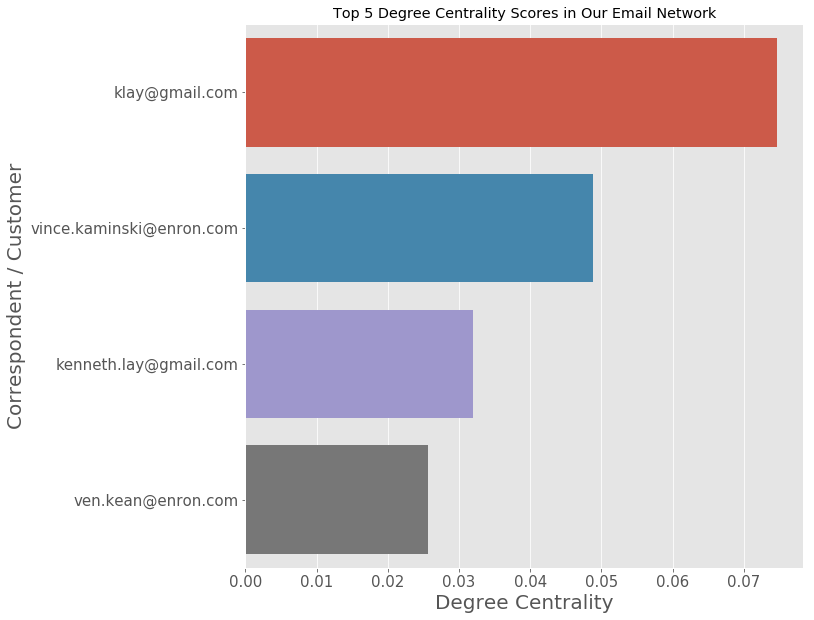

In [59]:
G = nx.from_pandas_edgelist(data, 'From', 'To', edge_attr=['Date','subject'])

cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 10))
_ = sb.barplot(x='centrality', y='name', data=cent[:5], orient='h')
_ = plt.xlabel('Degree Centrality', fontsize=20)
_ = plt.ylabel('Correspondent / Customer', fontsize=20)
_ = plt.title('Top 5 Degree Centrality Scores in Our Email Network')
_ = plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

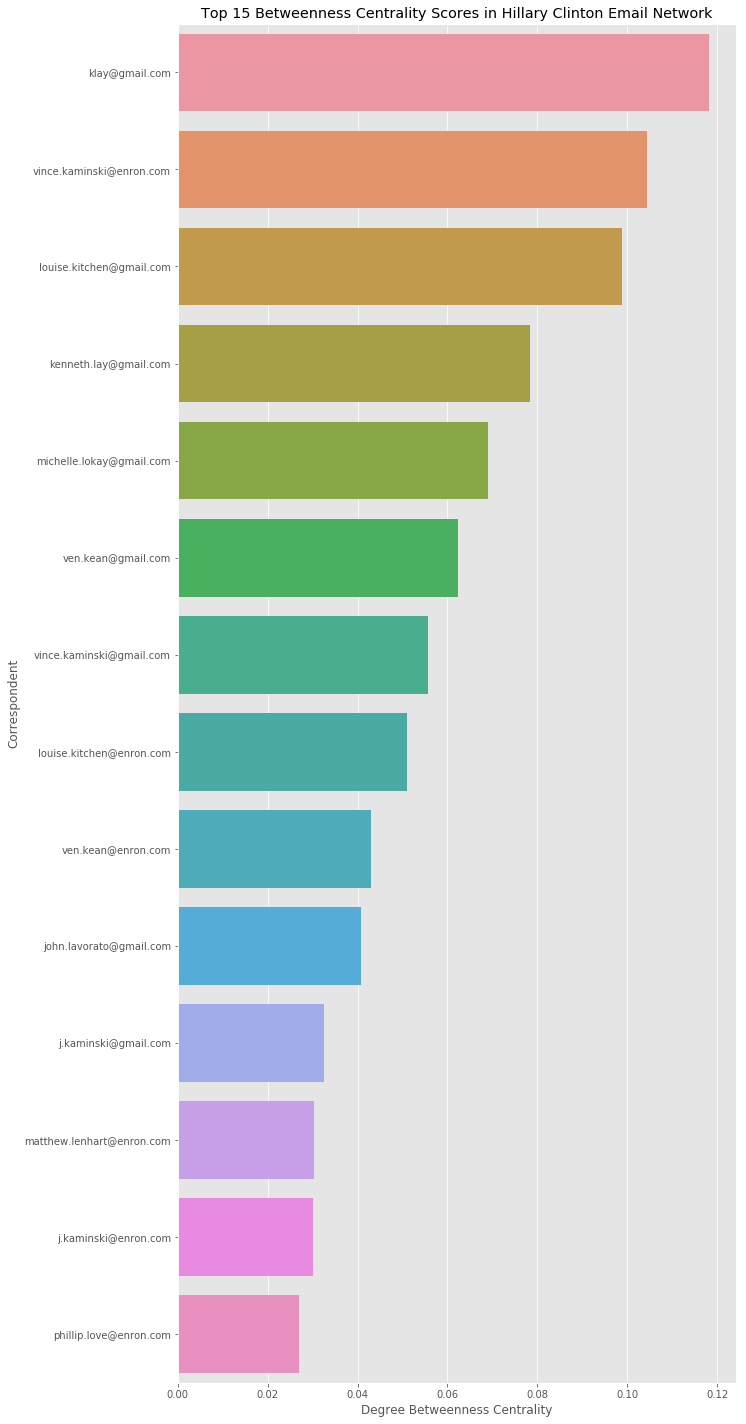

In [49]:
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(10, 25))
_ = sb.barplot(x='betweenness', y='name', data=bet[:15], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Hillary Clinton Email Network')
plt.show()

### Exploratory data analysis


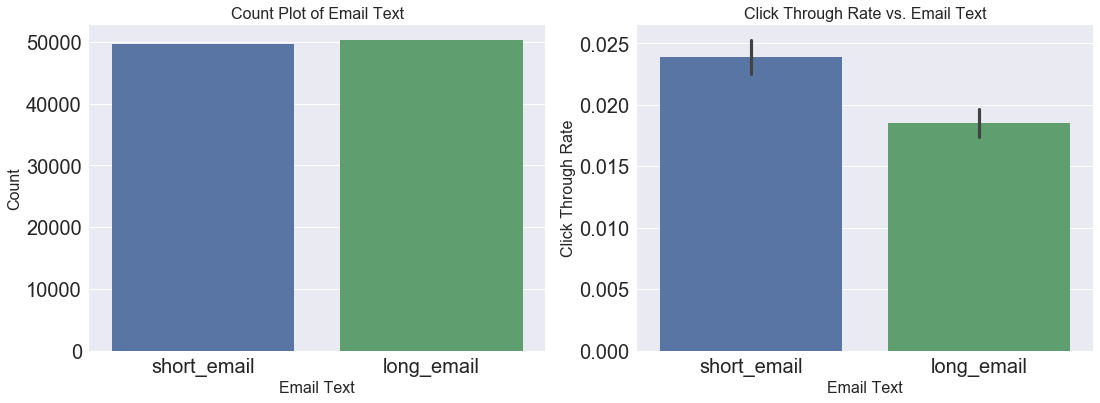

In [66]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sb.set(style="darkgrid")
sb.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})
sb.set(font_scale=2)
sb.countplot(x='email_text', data=data, ax=ax[0])
ax1[0].set_xlabel('Email Text', fontsize=16)
ax1[0].set_ylabel('Count', fontsize=16)
ax1[0].set_title('Count Plot of Email Text', fontsize=16)

sb.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
sb.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})
sb.set(font_scale=2)
ax1[1].set_xlabel('Email Text', fontsize=16)
ax1[1].set_ylabel('Click Through Rate', fontsize=16)
ax1[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
#plt.tight_layout()
plt.show()

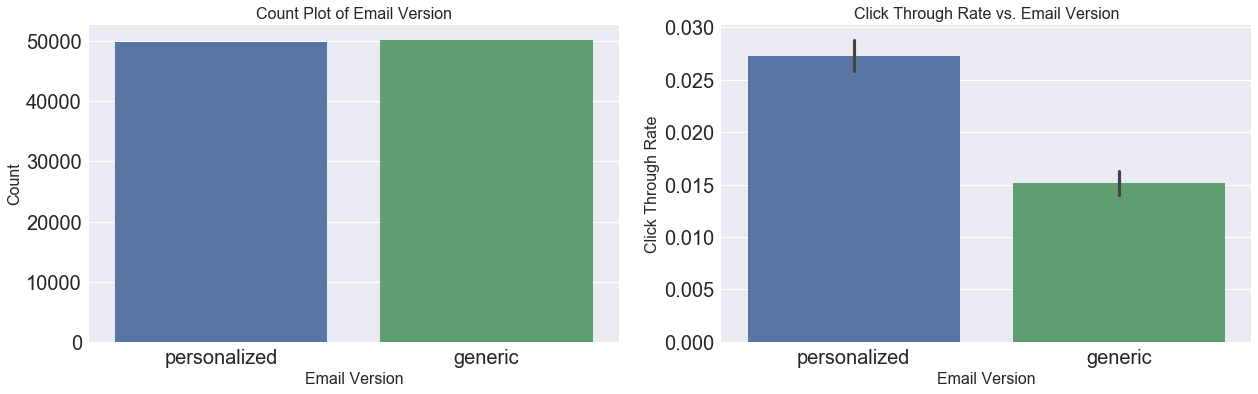

In [67]:

fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sb.countplot(x='email_version', data=data, ax=ax[0])
ax1[0].set_xlabel('Email Version', fontsize=16)
ax1[0].set_ylabel('Count', fontsize=16)
ax1[0].set_title('Count Plot of Email Version', fontsize=16)

sb.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax1[1].set_xlabel('Email Version', fontsize=16)
ax1[1].set_ylabel('Click Through Rate', fontsize=16)
ax1[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

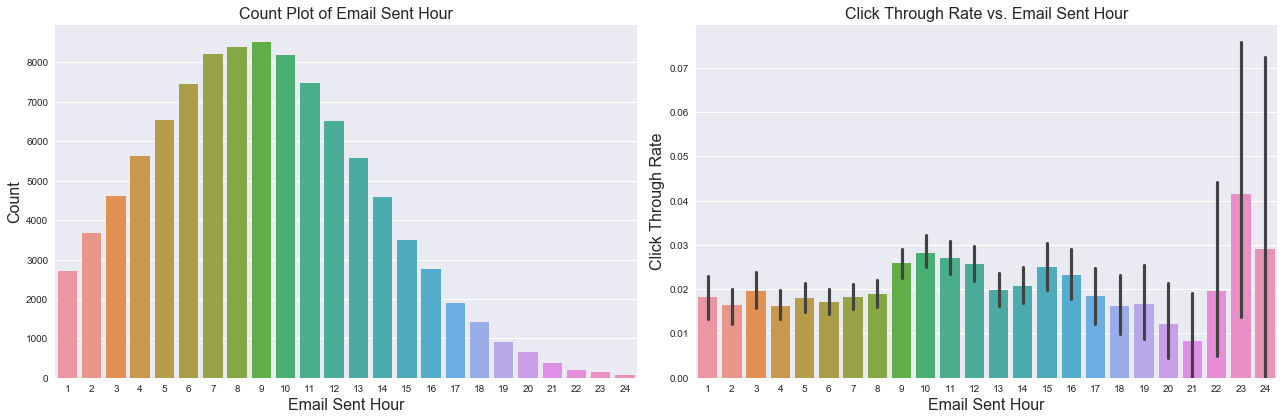

In [71]:
sb.set(font_scale=1)
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sb.countplot(x='hour', data=data, ax=ax[0])
ax1[0].set_xlabel('Email Sent Hour', fontsize=16)
ax1[0].set_ylabel('Count', fontsize=16)
ax1[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sb.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax1[1].set_xlabel('Email Sent Hour', fontsize=16)
ax1[1].set_ylabel('Click Through Rate', fontsize=16)
ax1[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

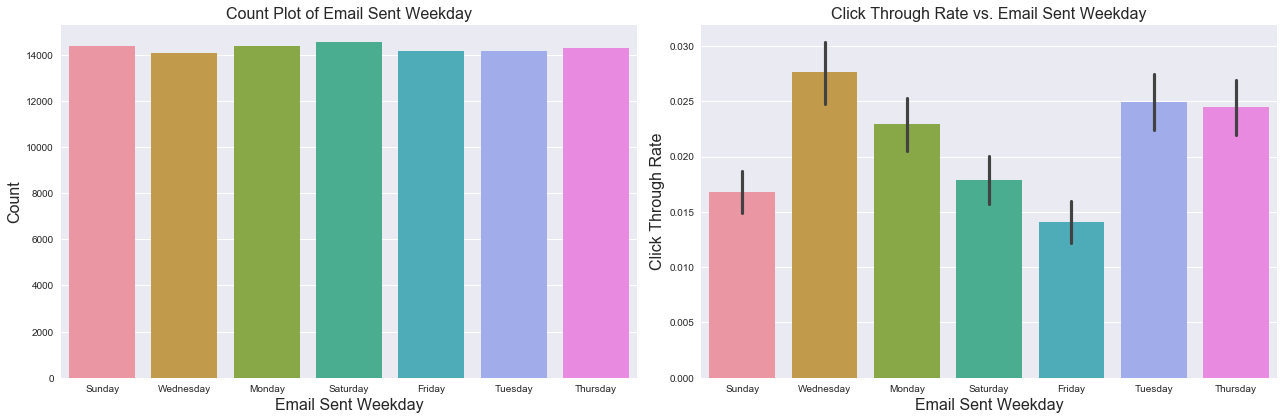

In [73]:
sb.set(font_scale=1)

fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sb.countplot(x='weekday', data=data, ax=ax[0])
ax1[0].set_xlabel('Email Sent Weekday', fontsize=16)
ax1[0].set_ylabel('Count', fontsize=16)
ax1[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sb.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax1[1].set_xlabel('Email Sent Weekday', fontsize=16)
ax1[1].set_ylabel('Click Through Rate', fontsize=16)
ax1[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

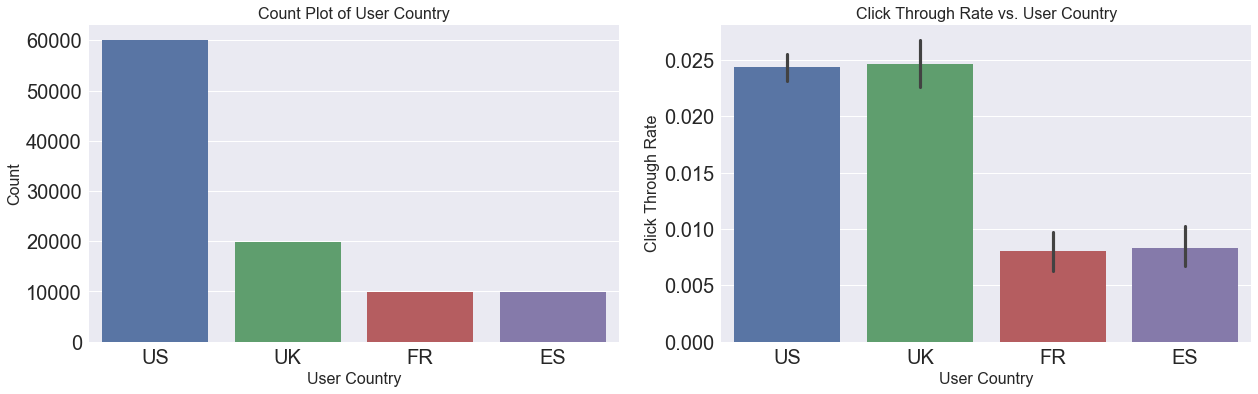

In [75]:
sb.set(font_scale=2)

fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sb.countplot(x='user_country', data=data, ax=ax[0])
ax1[0].set_xlabel('User Country', fontsize=16)
ax1[0].set_ylabel('Count', fontsize=16)
ax1[0].set_title('Count Plot of User Country', fontsize=16)

sb.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax1[1].set_xlabel('User Country', fontsize=16)
ax1[1].set_ylabel('Click Through Rate', fontsize=16)
ax1[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

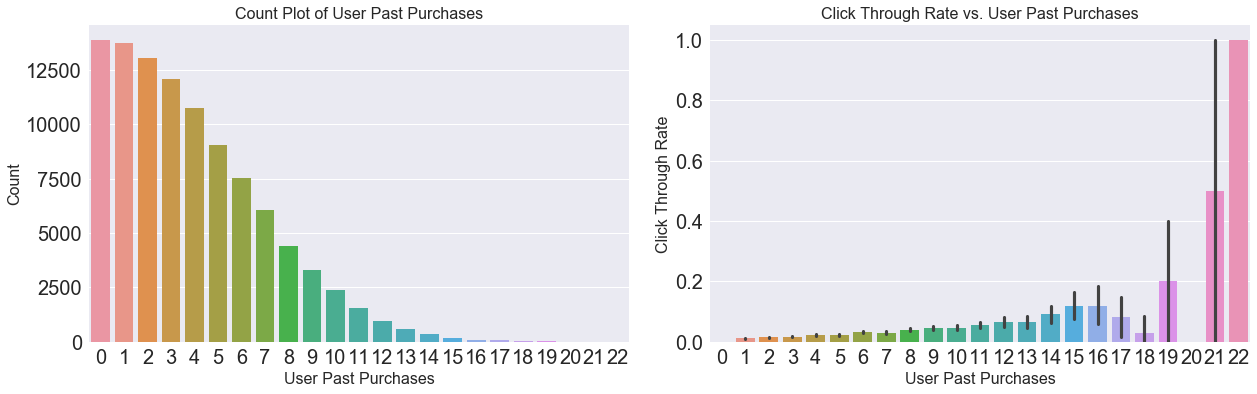

In [77]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sb.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax1[0].set_xlabel('User Past Purchases', fontsize=16)
ax1[0].set_ylabel('Count', fontsize=16)
ax1[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sb.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax1[1].set_xlabel('User Purchases', fontsize=16)
ax1[1].set_ylabel('Click Through Rate', fontsize=16)
ax1[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()


In [133]:
emails = pd.read_csv("email_table.csv",index_col="email_id")


### Data pre-processing


In [134]:

emails["paragraphs"] = np.where(emails.email_text == 'short_email',2,4)
del emails["email_text"]

emails["is_personal"] = (emails.email_version == "personalized").astype(np.int)
del emails["email_version"]

weekday2index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
emails["weekday"] = emails.weekday.map(weekday2index)

emails.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)

In [135]:
emails["response"] = "received"

open_users = pd.read_csv("email_opened_table.csv").email_id
emails.loc[open_users,"response"] = "opened"

click_users = pd.read_csv("link_clicked_table.csv").email_id
emails.loc[click_users,"response"] = 'clicked'

In [85]:
emails.to_csv("clean_emails.csv",index_label="email_id")


In [136]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_plotbar(key):
    grpresult = emails.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['clicked']].plot(kind='bar',title='click ratio vs. {}'.format(key))
    plt.ylabel('click ratio')
    return grpresult

In [277]:
X.head()

,purchases,paragraphs,is_personal,is_weekend,country_FR,country_UK,country_US
email_id,,,,,,,
85120,5,2,1,1,0,0,1
966622,2,4,1,1,0,1,0
777221,2,4,1,0,0,0,1
493711,1,2,0,0,0,1,0
106887,6,4,0,0,0,0,1


In [137]:
resp_lb_encoder = LabelEncoder()
cnty_lb_encoder = LabelEncoder()

X = emails.copy()
y = resp_lb_encoder.fit_transform(X.response)
del X["response"]

feat_names = ["hour","weekday","country","purchases","paragraphs","is_personal" ]
X = X.loc[:,feat_names]
X["country"] = cnty_lb_encoder.fit_transform(X.country)

chi2scores,_ = chi2(X,y)
fscores,_ = f_classif(X,y)

feat_scores = pd.DataFrame({"chi2scores":chi2scores,"fscores":fscores},index=feat_names)

In [138]:
feat_scores.sort_values(by='chi2scores',ascending=False)


,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
paragraphs,53.952439,81.209295


In [139]:
X = emails.copy()

,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,
955722,23,1,US,8,2,1,received
757910,10,1,US,4,4,0,received
127730,7,6,FR,9,2,0,received
367103,5,1,UK,5,2,0,received
845971,9,4,US,3,4,0,received


In [140]:
# select original features
# 'paragraphs' isn't an important feature, but I will include it, and see how RF say about it
X = X.loc[:,["country","purchases","paragraphs","is_personal"] ]

# create new feature
X['is_weekend'] = (emails.weekday>=5).astype(int)

# One-Hot-Encode 'country' feature
X = pd.get_dummies(X,columns=["country"],drop_first=True)

# prepare the target
y = (emails.response == 'clicked').astype(int)

### Machine learning experiments


In [216]:
seed = 9999

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33333,random_state = seed)


In [217]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
Xtrain, ytrain = sm.fit_sample(Xtrain, ytrain.ravel())
#Xtest, ytest = sm.fit_sample(Xtest, ytest.ravel())


In [159]:
print ('Train set shape: {}, positive ratio={:.3f}'.format(Xtrain.shape,ytrain.mean()))
print ('Test set shape: {}, positive ratio={:.3f}'.format(Xtest.shape,ytest.mean()))


Train set shape: (130530, 7), positive ratio=0.500
Test set shape: (33333, 7), positive ratio=0.022


In [218]:
Xtest.columns = ['f0', 'f1','f2', 'f3', 'f4', 'f5', 'f6']


In [219]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [220]:
test_matrix.feature_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']

In [161]:
params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.768667+0.000734177	test-auc:0.768383+0.00254694
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[05:38:40] src/tree/updater_prune.cc:74:

[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-auc:0.811588+0.00255148	test-auc:0.810931+0.00326172
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:38:45] src/tree/updater_prune.cc:74:

[05:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[05:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[26]	train-auc:0.818494+0.00122001	test-auc:0.817767+0.0022326
[05:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[27]	train-auc:0.818863+0.00126682	test-a

[39]	train-auc:0.822385+0.000996592	test-auc:0.821525+0.00223177
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-auc:0.822772+0.00102379	test-auc:0.821832+0.00236147
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 p

[05:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[53]	train-auc:0.826059+0.00039701	test-auc:0.825091+0.00296937
[05:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[05:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[54]	train-auc:0.826302+0.00030268	test-auc:0.825375+0.00298214
[05:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pr

[05:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[66]	train-auc:0.828124+0.000652543	test-auc:0.827092+0.00257375
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[67]	train-auc:0.828393+0.000612187	test-auc:0.827346+0.00254745
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 

[79]	train-auc:0.830215+0.000995087	test-auc:0.829114+0.00277756
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-auc:0.830356+0.00102317	test-auc:0.829245+0.00277007
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 p

[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[93]	train-auc:0.832969+0.000892664	test-auc:0.831812+0.00287678
[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[05:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:39:12] src/tree/updater_prune.cc:74

[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[106]	train-auc:0.835099+0.0010655	test-auc:0.833909+0.00288152
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[05:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[107]	train-auc:0.835162+0.00113125	test

[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[119]	train-auc:0.836381+0.00114004	test-auc:0.835164+0.00305919
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-auc:0.836655+0.00122133	test-auc:0.835408+0.00306854
[05:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 

[05:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[132]	train-auc:0.838254+0.000972406	test-auc:0.837074+0.00303391
[05:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[05:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[05:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[133]	train-auc:0.838339+0.00104057	test-auc:0.83717+0.00302649
[05:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 

[145]	train-auc:0.839527+0.000902479	test-auc:0.838372+0.002975
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[146]	train-auc:0.839699+0.000881281	test-auc:0.838517+0.00285354
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 

[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[159]	train-auc:0.840706+0.000735107	test-auc:0.839441+0.00277033
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:39:33] src/tree/updater_prune.cc:7

[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[172]	train-auc:0.841498+0.000747144	test-auc:0.840194+0.00281381
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:39:38] src/tree/updater_prune.cc:7

[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[185]	train-auc:0.842356+0.000815121	test-auc:0.840991+0.00298218
[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[05:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[186]	train-auc:0.842412+0.000793975	test-auc:0.841036+0.00296849
[05:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 

[05:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[198]	train-auc:0.843171+0.000603857	test-auc:0.841823+0.00310392
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[199]	train-auc:0.843187+0.000621279	test-auc:0.841839+0.00311849
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 

[211]	train-auc:0.843671+0.000705446	test-auc:0.84236+0.00299691
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[212]	train-auc:0.843686+0.000709237	test-auc:0.84237+0.00298697
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[05:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[05:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 

[05:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[225]	train-auc:0.844262+0.000749638	test-auc:0.842838+0.00298337
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[05:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:39:57] src/tree/updater_prune.cc:7

[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[238]	train-auc:0.844588+0.000785112	test-auc:0.843091+0.00289175
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[05:40:01] src/tree/updater_prune.cc:7

[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[251]	train-auc:0.84495+0.00074486	test-auc:0.843435+0.00292319
[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[05:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[252]	train-auc:0.844963+0.000742818	tes

[05:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[264]	train-auc:0.845232+0.000783564	test-auc:0.843703+0.00287512
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[265]	train-auc:0.845221+0.000775452	test-auc:0.843701+0.0028727
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[05:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0

[277]	train-auc:0.845584+0.000688526	test-auc:0.843946+0.00287322
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[278]	train-auc:0.845612+0.000697846	test-auc:0.843978+0.00286596
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[05:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[05:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 

[05:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[05:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[05:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[05:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[291]	train-auc:0.846094+0.000651644	test-auc:0.844412+0.00285494
[05:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[05:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[05:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[05:40:19] src/tree/updater_prune.cc:7

In [162]:
n_best_trees = cv_results.shape[0]
print ("best number of trees: {}".format(n_best_trees))

best number of trees: 300


In [163]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.769001
[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-auc:0.779399
[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-auc:0.791577
[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-auc:0.791071
[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-auc:0.798726
[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-auc:0.797841
[05:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-auc:0.803334
[05:40:53] src/tree/updater_prune.cc:74: tree pruning e

[05:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[61]	train-auc:0.827232
[05:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[62]	train-auc:0.827319
[05:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[63]	train-auc:0.827579
[05:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[64]	train-auc:0.827937
[05:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[65]	train-auc:0.8279
[05:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[66]	train-auc:0.827858
[05:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[67]	train-auc:0.82813
[05:40:59] src/tree/updater_prune.cc:74: tree pruni

[121]	train-auc:0.837679
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[122]	train-auc:0.837777
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[123]	train-auc:0.837751
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[124]	train-auc:0.837931
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[125]	train-auc:0.837918
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[126]	train-auc:0.837932
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[127]	train-auc:0.838159
[05:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[128]	train-auc:0.838157
[05:41:05] src/t

[181]	train-auc:0.841489
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[182]	train-auc:0.841668
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[183]	train-auc:0.84172
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[184]	train-auc:0.842144
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[185]	train-auc:0.842149
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[186]	train-auc:0.84221
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[187]	train-auc:0.842241
[05:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[188]	train-auc:0.842225
[05:41:10] src/tre

[05:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[242]	train-auc:0.843861
[05:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[243]	train-auc:0.843882
[05:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[244]	train-auc:0.843947
[05:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[245]	train-auc:0.843962
[05:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[246]	train-auc:0.843965
[05:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[247]	train-auc:0.843961
[05:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[248]	train-auc:0.843973
[05:41:16] src/tree/updater_prune.cc:74: 

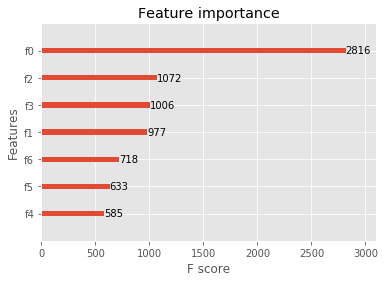

In [164]:
xgb.plot_importance(gbt)


In [165]:
print ("n_best_trees={},xgboost parameters: ".format(n_best_trees))
params

n_best_trees=300,xgboost parameters: 


{'colsample_bytree': 0.8,
 'early_stopping_rounds': 30,
 'eta': 0.1,
 'eval_metric': 'auc',
 'max_depth': 6,
 'num_rounds': 300,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [166]:
# define a function, avoid pollute the current namespace
def validation_roc():
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.2,random_state=seed)
    
    train_only_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid)
    
    # retrain on training set
    gbt_train_only = xgb.train(params, train_only_matrix, n_best_trees)
    
    # predict on validation set
    yvalid_probas = gbt_train_only.predict(valid_matrix, ntree_limit=n_best_trees)
    
    d = {}
    d['FPR'],d['TPR'],d['Threshold'] = roc_curve(yvalid,yvalid_probas)
    return pd.DataFrame(d)

In [167]:
roc_results = validation_roc()


[05:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[05:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[05:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[05:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[05:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[05:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[05:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[05:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_

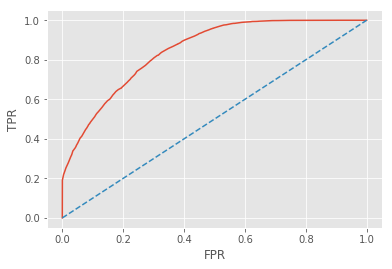

In [268]:
_ = plt.figure()
plt.plot(roc_results.FPR,roc_results.TPR)
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], linestyle='--')


In [241]:
roc_results.loc[(roc_results.TPR > 0.8) & (roc_results.TPR < 0.99),:]


,FPR,TPR,Threshold
545,0.298839,0.806474,0.519907
546,0.300069,0.808230,0.518140
547,0.300992,0.809680,0.516485
548,0.309218,0.818765,0.515924
549,0.312524,0.822506,0.506873
550,0.315446,0.823116,0.501010
551,0.319136,0.828613,0.495743
552,0.321596,0.832506,0.494737
553,0.322288,0.833422,0.485564
554,0.322442,0.833499,0.478149


In [260]:
# choose a threshold based on ROC
# FPR=0.292380, TPR=0.630363, Threshold=0.029118
pos_prob_threshold =0.281788

def adjust_predict(matrix):
    y_probas = gbt.predict(matrix, ntree_limit=n_best_trees)
    return (y_probas > pos_prob_threshold).astype(int)

In [261]:
ytrain_pred = adjust_predict(train_matrix)
print (classification_report(ytrain,ytrain_pred))

             precision    recall  f1-score   support

          0       0.96      0.44      0.61     65265
          1       0.64      0.98      0.77     65265

avg / total       0.80      0.71      0.69    130530



In [189]:
test_matrix.feature_names

['purchases',
 'paragraphs',
 'is_personal',
 'is_weekend',
 'country_FR',
 'country_UK',
 'country_US']

In [265]:
ytest_pred = adjust_predict(test_matrix)
print (classification_report(ytest,ytest_pred))

             precision    recall  f1-score   support

          0       0.99      0.45      0.62     32616
          1       0.03      0.81      0.06       717

avg / total       0.97      0.46      0.61     33333



In [224]:
print ("test precision: {:.2f}%".format(precision_score(ytest,ytest_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(ytest,ytest_pred) * 100))

test precision: 3.91%
test recall: 65.41%


             precision    recall  f1-score   support

          0       0.99      0.45      0.62     32616
          1       0.03      0.81      0.06       717

avg / total       0.97      0.46      0.61     33333


Confusion matrix:
[[14612 18004]
 [  135   582]] 

TN:  14612
TP:  582
FN:  135
FP:  18004
             precision    recall  f1-score   support

          0       0.99      0.45      0.62     32616
          1       0.03      0.81      0.06       717

avg / total       0.97      0.46      0.61     33333



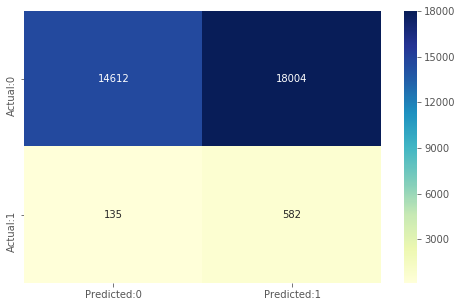

In [256]:
from sklearn import metrics
import seaborn as sn


print(metrics.classification_report(ytest,ytest_pred))
print ('\nConfusion matrix:')
c_matrix = metrics.confusion_matrix(ytest,ytest_pred)
print (c_matrix,"\n")
print ('TN: ', c_matrix[0,0])
print ('TP: ', c_matrix[1,1])
print ('FN: ', c_matrix[1,0])
print ('FP: ', c_matrix[0,1])
metrics.accuracy_score(ytest,ytest_pred)


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,ytest_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(ytest,ytest_pred))

In [267]:
gb_fpr, gb_tpr, gb_thresholds = roc_curve(ytest,ytest_pred)
gb_recall = recall_score(ytest,ytest_pred)
gb_auc = auc(gb_fpr, gb_tpr)
print( "XGBoost (AUC, Recall) {0}".format((gb_auc,gb_recall)))



XGBoost (AUC, Recall) (0.629858231142556, 0.8117154811715481)


Random Forest, SVM, Gradient Boosting

In [3]:
email_tbl = pd.read_csv('email_table.csv')
email_opened_tbl = pd.read_csv('email_opened_table.csv')
link_clicked_tbl = pd.read_csv('link_clicked_table.csv')

In [4]:
percent_opened = (email_tbl[email_tbl.email_id.isin(email_opened_tbl.email_id)].shape[0] / float(email_tbl.shape[0]))*100
percent_clicked = (email_tbl[email_tbl.email_id.isin(link_clicked_tbl.email_id)].shape[0] / float(email_tbl.shape[0]))*100
print ("Percent opened {0}".format(percent_opened))
print ("Percent clicked {0}".format(percent_clicked))


Percent opened 10.345
Percent clicked 2.119


{'boxes': [<matplotlib.lines.Line2D at 0x1a097f4470>],
 'caps': [<matplotlib.lines.Line2D at 0x1a097f4e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x101dc8b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x101dc8710>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a097f45c0>,
  <matplotlib.lines.Line2D at 0x1a097f4a58>]}

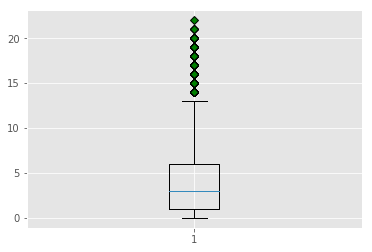

In [5]:
import matplotlib.pyplot as plt
green_diamond = dict(markerfacecolor='g', marker='D')

plt.boxplot(email_tbl.user_past_purchases, flierprops=green_diamond)


In [6]:
non_outliers = email_tbl[email_tbl.user_past_purchases < 12]


In [7]:
# Add a 'link_clicked' column to the dataframe
clicked_emails = set(link_clicked_tbl.email_id)
non_outliers['link_clicked'] = non_outliers.email_id.apply((lambda x: 1 if x in clicked_emails else 0))

In [8]:
non_outliers.head()


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,link_clicked
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,1
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [9]:
non_outliers.user_country.value_counts(normalize=True)


US    0.600942
UK    0.199662
FR    0.099754
ES    0.099642
Name: user_country, dtype: float64

In [10]:
us_uk_emails = non_outliers[non_outliers.user_country.isin(['US','UK'])]


In [11]:
us_uk_emails['country_US'] = us_uk_emails.user_country.apply((lambda x: 1 if x == 'US' else 0))


In [12]:
us_uk_emails['is_short'] = us_uk_emails.email_text.apply((lambda x: 1 if x == 'short_email' else 0))

In [13]:
us_uk_emails['is_generic'] = us_uk_emails.email_version.apply((lambda x: 1 if x == 'generic' else 0))

In [14]:
us_uk_emails[us_uk_emails['link_clicked'] == 1].hour.value_counts(normalize=True)


10    0.107761
9     0.105528
11    0.095477
12    0.078169
8     0.077052
7     0.068677
6     0.060302
5     0.054160
13    0.053043
14    0.044668
15    0.044109
4     0.041318
3     0.040759
16    0.030709
2     0.028476
1     0.024567
17    0.017309
18    0.010609
19    0.006700
23    0.003350
20    0.003350
21    0.001675
22    0.001675
24    0.000558
Name: hour, dtype: float64

In [15]:
evening_hours = [19,20,21,22,23,24]
us_uk_emails['hour_sent'] = us_uk_emails.hour.apply((lambda x: 'EVENING' if x in evening_hours else str(x)))

In [16]:
weekday_dummies = pd.get_dummies(us_uk_emails.weekday,prefix='weekday').drop('weekday_Sunday',axis=1)
hour_dummies = pd.get_dummies(us_uk_emails.hour_sent,prefix='hour_sent').drop('hour_sent_EVENING',axis=1)

In [17]:
# Create the feature matrix
df = us_uk_emails[['user_past_purchases','is_short','is_generic','link_clicked']]
df = df.join(weekday_dummies)
df = df.join(hour_dummies)
y = df.pop('link_clicked').values
X = df.values

In [43]:
def undersample(X,y):
    majority_X = X[y == 0]
    majority_y = y[y == 0]
    minority_y = y[y == 1]
    minority_X = X[y == 1]
    minority_size = y[y == 1].shape[0]
    
    inds = np.arange(minority_size)
    samples = np.random.choice(inds, minority_size,replace=False)
    
    undersampled_X = np.concatenate((majority_X[samples],minority_X), axis=0)
    undersampled_y = np.concatenate((majority_y[samples],minority_y), axis=0)
    return (undersampled_X, undersampled_y)

In [42]:
def oversample(X,y):
    majority_X = X[y == 0]
    majority_y = y[y == 0]
    minority_y = y[y == 1]
    minority_X = X[y == 1]
    majority_size = y[y == 0].shape[0]
    
    inds = np.arange(majority_size)
    samples = np.random.choice(inds, majority_size,replace=True)
    
    oversampled_X = np.concatenate((minority_X[samples],majority_X), axis=0)
    oversampled_y = np.concatenate((minority_y[samples],majority_y), axis=0)
    return (oversampled_X, oversampled_y)

In [61]:
# Split the data into a training set and validation set
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.33333,random_state = seed)

#X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

In [44]:
# Undersample the training data to balance the classes
X_sub,y_sub = undersample(X_train,y_train)

In [19]:
# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sub, y_sub = sm.fit_sample(X_train, y_train)


In [45]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# Train and tune a random forest classifer 
rf_params = {'n_estimators':[20,30,40,50],
             'criterion':['gini','entropy'],
             'max_features':['auto','log2'],
             'min_samples_leaf':[1,2,5,10,11,12,13,14,15],
             'min_samples_split':[2, 3, 5, 7,10]}
rf_clf = GridSearchCV(RandomForestClassifier(),rf_params, scoring = 'roc_auc')
rf_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'log2'], 'min_samples_leaf': [1, 2, 5, 10, 11, 12, 13, 14, 15], 'min_samples_split': [2, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
rf_clf.best_params_


{'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 7,
 'n_estimators': 40}

In [87]:
rf_clf = RandomForestClassifier(n_estimators=40, max_depth = 3, criterion='gini',max_features='auto'
                                ,min_samples_leaf=10,min_samples_split=7)
rf_clf.fit(X_sub,y_sub)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rf_pred = rf_clf.predict(X_val)


             precision    recall  f1-score   support

          0       0.98      0.61      0.76      7647
          1       0.03      0.58      0.06       175

avg / total       0.96      0.61      0.74      7822


Confusion matrix:
[[4700 2947]
 [  73  102]] 

TN:  4700
TP:  102
FN:  73
FP:  2947
             precision    recall  f1-score   support

          0       0.98      0.61      0.76      7647
          1       0.03      0.58      0.06       175

avg / total       0.96      0.61      0.74      7822



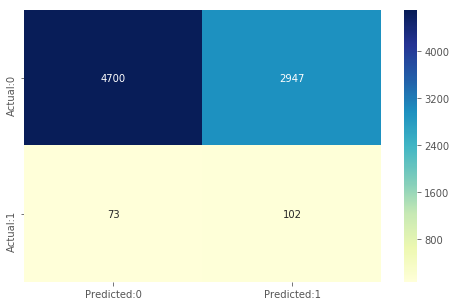

In [89]:
from sklearn import metrics
import seaborn as sn


print(metrics.classification_report(y_val,rf_pred))
print ('\nConfusion matrix:')
c_matrix = metrics.confusion_matrix(y_val,rf_pred)
print (c_matrix,"\n")
print ('TN: ', c_matrix[0,0])
print ('TP: ', c_matrix[1,1])
print ('FN: ', c_matrix[1,0])
print ('FP: ', c_matrix[0,1])
metrics.accuracy_score(y_val,rf_pred)


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,rf_pred))


In [178]:
feature_list = list(df.columns)


In [185]:
from sklearn.tree import export_graphviz
import pydot
tree_small = rf_clf.estimators_[5]
export_graphviz(tree_small, out_file = 'small_tree.dot',class_names=['0','1'], feature_names = feature_list, rounded = True, precision = 1)


In [186]:
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')


In [187]:
graph.write_png('small_tree.png')

In [92]:


# Train and tune a logistic regression classifer 
lr_params = {'C':[0.1,0.2, 0.3, 0.4]}
lr_clf = GridSearchCV(LogisticRegression(),lr_params,scoring='roc_auc')
lr_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.3, 0.4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [55]:
lr_clf.best_params_


{'C': 0.1}

In [93]:
lr_clf = LogisticRegression(C=0.1)
lr_clf.fit(X_sub,y_sub)
lr_pred = lr_clf.predict(X_val)


             precision    recall  f1-score   support

          0       0.98      0.67      0.79      7647
          1       0.04      0.55      0.07       175

avg / total       0.96      0.66      0.78      7822


Confusion matrix:
[[5097 2550]
 [  79   96]] 

TN:  5097
TP:  96
FN:  79
FP:  2550
             precision    recall  f1-score   support

          0       0.98      0.67      0.79      7647
          1       0.04      0.55      0.07       175

avg / total       0.96      0.66      0.78      7822



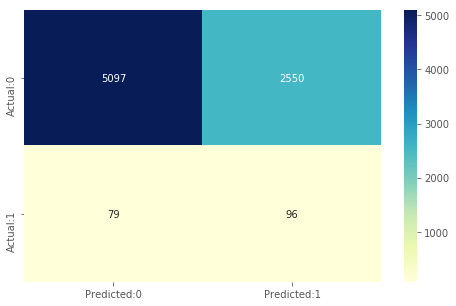

In [94]:
from sklearn import metrics
import seaborn as sn


print(metrics.classification_report(y_val,lr_pred))
print ('\nConfusion matrix:')
c_matrix = metrics.confusion_matrix(y_val,lr_pred)
print (c_matrix,"\n")
print ('TN: ', c_matrix[0,0])
print ('TP: ', c_matrix[1,1])
print ('FN: ', c_matrix[1,0])
print ('FP: ', c_matrix[0,1])
metrics.accuracy_score(y_val,lr_pred)


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,lr_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,lr_pred))

In [56]:
# Train and tune a Gradient Boosting classifer 
gbc_params = {'learning_rate':[0.1,0.2,0.3,0.4],
              'n_estimators':[100,200],
              'min_samples_leaf':[1,5,7,8],
              'min_samples_split':[2, 3, 5, 7,10],
              'max_features':['auto','log2']
             }
gbc_clf = GridSearchCV(GradientBoostingClassifier(),gbc_params,scoring='roc_auc')
gbc_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [100, 200], 'min_samples_leaf': [1, 5, 7, 8], 'min_samples_split': [2, 3, 5, 7, 10], 'max_features': ['auto', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [57]:
gbc_clf.best_params_


{'learning_rate': 0.1,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 5,
 'n_estimators': 100}

In [96]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.1,max_features='log2',min_samples_leaf=7,min_samples_split=5
                                                 ,n_estimators=100)
gbc_clf.fit(X_sub,y_sub)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [97]:
gbc_pred = gbc_clf.predict(X_val)


             precision    recall  f1-score   support

          0       0.99      0.60      0.74      7647
          1       0.03      0.61      0.06       175

avg / total       0.96      0.60      0.73      7822


Confusion matrix:
[[4556 3091]
 [  69  106]] 

TN:  4556
TP:  106
FN:  69
FP:  3091
             precision    recall  f1-score   support

          0       0.99      0.60      0.74      7647
          1       0.03      0.61      0.06       175

avg / total       0.96      0.60      0.73      7822



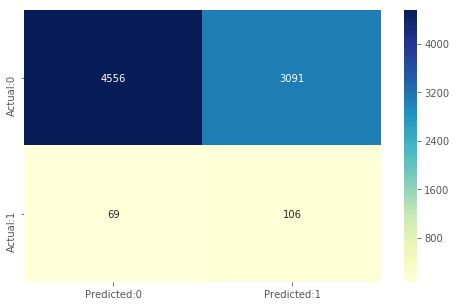

In [98]:
from sklearn import metrics
import seaborn as sn


print(metrics.classification_report(y_val,gbc_pred))
print ('\nConfusion matrix:')
c_matrix = metrics.confusion_matrix(y_val,gbc_pred)
print (c_matrix,"\n")
print ('TN: ', c_matrix[0,0])
print ('TP: ', c_matrix[1,1])
print ('FN: ', c_matrix[1,0])
print ('FP: ', c_matrix[0,1])
metrics.accuracy_score(y_val,gbc_pred)


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,gbc_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,gbc_pred))

In [61]:
# Train and tune a Support Vector classifer 
svc_params = {'kernel':['rbf','sigmoid','linear','poly'],
              'C':[0.1,0.5,1,5,10],
              'degree':[1,3,5],
              'coef0':[0.5,0.6,0.7]
             }
svc_clf = GridSearchCV(SVC(),svc_params,scoring='roc_auc')
svc_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 'C': [0.1, 0.5, 1, 5, 10], 'degree': [1, 3, 5], 'coef0': [0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [ ]:
import seaborn as sn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(C=0.1)
lr.fit(X_sub,y_sub)
lr_pred = lr.predict(X_val)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_auc = auc(lr_fpr, lr_tpr)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,lr_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,lr_pred))

rf = RandomForestClassifier(criterion = 'entropy',
                            max_features = 'auto',
                            min_samples_leaf = 12,
                            min_samples_split = 7,
                            n_estimators= 40)
rf.fit(X_sub,y_sub)
rf_pred = rf.predict(X_val)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_auc = auc(rf_fpr, rf_tpr)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,rf_pred))

gbc = GradientBoostingClassifier(learning_rate= 0.1,
                                 max_features ='log2',
                                 min_samples_leaf = 5,
                                 min_samples_split = 2,
                                 n_estimators =100)
gbc.fit(X_sub,y_sub)
gbc_pred = gbc.predict(X_val)
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_val, gbc_pred)
gbc_recall = recall_score(y_val, gbc_pred)
gbc_auc = auc(gbc_fpr, gbc_tpr)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,gbc_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,gbc_pred))

svc = SVC(C=1, coef0=0.6, degree=1,kernel='poly')
svc.fit(X_sub,y_sub)
svc_pred = svc.predict(X_val)
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_val, svc_pred)
svc_recall = recall_score(y_val, svc_pred)
svc_auc = auc(svc_fpr, svc_tpr)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,svc_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_val,svc_pred))



In [46]:
print( "Logistic Regression (AUC, Recall) {0}".format((lr_auc,lr_recall)))
print( "Random Forest (AUC, Recall) {0}".format((rf_auc,rf_recall)))
print( "Gradient Boosting Classifier (AUC, Recall) {0}".format((gbc_auc,gbc_recall)))
#print( "Support Vector Classifier (AUC, Recall) {0}".format((svc_auc,svc_recall)))


Logistic Regression (AUC, Recall) (0.6504389471418467, 0.6588235294117647)
Random Forest (AUC, Recall) (0.6473724670213092, 0.6941176470588235)
Gradient Boosting Classifier (AUC, Recall) (0.6382237631069155, 0.6882352941176471)
